In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# <center> <h1 style="background-color:indigo; color:white" >Spaceship - Titanic &#128760;</h1>
<center><img
src="https://cdna.artstation.com/p/assets/images/images/031/622/800/large/vitaliy-ostaschenko-moncala2.jpg?1604144433"
style="width:90%;height:40%;">
</center>   

<a class="anchor" id="0."></a>
# <center> <h1 style="background-color:indigo; color:white" >Contents &#128214;</h1><center>

* [Import Libraries &#128218;](#1.)
* [Functions](#2.)
* [Load Data &#128229;](#3.)
* [Feature Engineering](#4.)
* * [Train Values Analyze &#128270;](#4.1.)
* * * [Analysis of Categorical Variables &#128202;](#4.1.1.)
* * * * [Handling Missing Values](#4.1.1.1.)
* * * [Analysis of Numerical Variables &#128202;](#4.1.2.)
* * * * [Handling Missing Values](#4.1.2.1.)
* * * * [Target variable analysis with numerical variables](#4.1.2.2.)
* * * [Checking for Missing Data](#4.1.3.)
* * * [One Hot Encoding](#4.1.4.)
* * * [Editing Train Data](#4.1.5.)
* * [Test Values Analyze](#4.2.)
* * * [Analysis of Categorical Variables (test) &#128202;](#4.2.1.)
* * * * [Handling Missing Values (test)](#4.2.1.1.)
* * * [Analysis of Numerical Variables (test) &#128202;](#4.2.2.)
* * * * [Handling Missing Values (test)](#4.2.2.1.)
* * * [Checking for Missing Data (test)](#4.2.3.)
* * * [One Hot Encoding (test)](#4.2.4.)
* * * [Editing Test Data](#4.2.5.)
* [Random Forest &#127795;](#5.)
* [Gradient Boosting Machine &#128297;](#6.)
* [eXtreme Gradient Boosting &#128295;](#7.)
* [Light Gradient Boosting Machine &#128294;](#8.)
* [Accuracy table of models &#128187;](#9.)
* [THANK YOU &#127881;](#10.)

<a class="anchor" id="1."> 
<center> <h1 style="background-color:indigo; color:white" >Import Libraries &#128218;</h1>
    <center>
 <a/>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, validation_curve, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<a class="anchor" id="2."> 
<center> <h1 style="background-color:indigo; color:white" >Functions</h1>
    <center>
 <a/>

In [4]:
def cat_summary(dataframe,col_name, hue_, plot=False):
    print(pd.DataFrame({"Count": dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe),
                        "TARGET_MEAN": dataframe.groupby(col_name)[hue_].mean()}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe, hue = hue_, palette='rocket')
        plt.show()

In [5]:
def cat_summary_test(dataframe,col_name, plot=False):
    print(pd.DataFrame({"Count": dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe,palette='rocket')
        plt.show()

In [6]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

In [7]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [8]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='r')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True) 

[back to contents &#10548;](#0.)
<a class="anchor" id="3."> 
<center> <h1 style="background-color:indigo; color:white" >Load Data &#128229;</h1>
    <center>
 <a/>

In [9]:
train = pd.read_csv("../input/spaceship-titanic/train.csv")
test = pd.read_csv("../input/spaceship-titanic/test.csv")

[back to contents &#10548;](#0.)
<a class="anchor" id="4."> 
<center> <h1 style="background-color:indigo; color:white" >Feature Engineering</h1>
    <center>
 <a/>

In [10]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000,False,0.000,0.000,0.000,0.000,0.000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000,False,109.000,9.000,25.000,549.000,44.000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000,True,43.000,3576.000,0.000,6715.000,49.000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000,False,0.000,1283.000,371.000,3329.000,193.000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000,False,303.000,70.000,151.000,565.000,2.000,Willy Santantines,True


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [12]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000,False,0.000,0.000,0.000,0.000,0.000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000,False,109.000,9.000,25.000,549.000,44.000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000,True,43.000,3576.000,0.000,6715.000,49.000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000,False,0.000,1283.000,371.000,3329.000,193.000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000,False,303.000,70.000,151.000,565.000,2.000,Willy Santantines,True


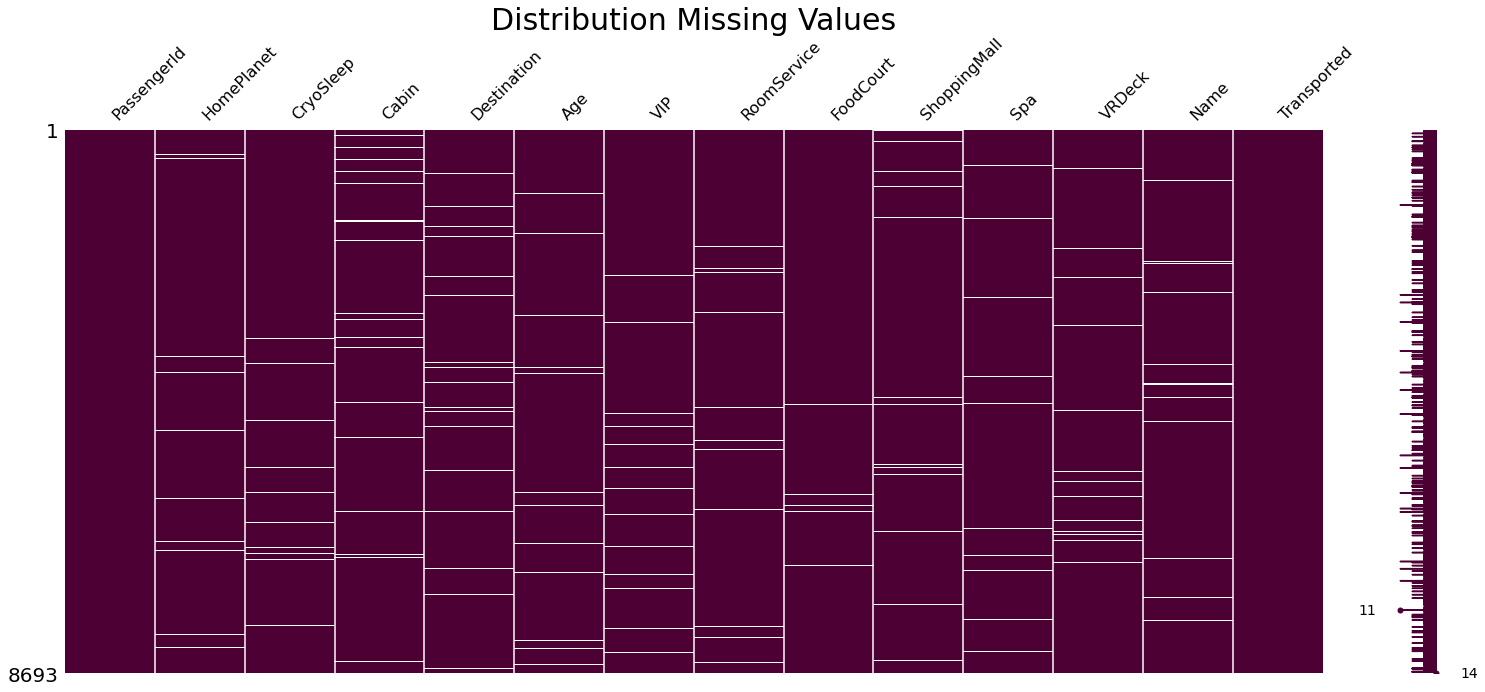

In [13]:
msno.matrix(train, color=(0.3, 0, 0.2))
plt.title('Distribution Missing Values',fontsize=30);

In [14]:
# Replace NaN's with outliers for now (so we can split feature)
train['Cabin'].fillna('X/9999/X', inplace=True)
test['Cabin'].fillna('X/9999/X', inplace=True)

In [15]:
# New features - train 
train['Deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

In [16]:
# New features - test
test['Deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

In [17]:
# Put Nan's back in (we will fill these later)
train.loc[train['Deck']=='X', 'Deck']=np.nan
train.loc[train['Number']==9999, 'Number']=np.nan
train.loc[train['Side']=='X', 'Side']=np.nan
test.loc[test['Deck']=='X', 'Deck']=np.nan
test.loc[test['Number']==9999, 'Number']=np.nan
test.loc[test['Side']=='X', 'Side']=np.nan

In [18]:
# Drop Cabin (we don't need it anymore)
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

In [19]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.000,False,0.000,0.000,0.000,0.000,0.000,Maham Ofracculy,False,B,0.000,P
1,0002_01,Earth,False,TRAPPIST-1e,24.000,False,109.000,9.000,25.000,549.000,44.000,Juanna Vines,True,F,0.000,S
2,0003_01,Europa,False,TRAPPIST-1e,58.000,True,43.000,3576.000,0.000,6715.000,49.000,Altark Susent,False,A,0.000,S
3,0003_02,Europa,False,TRAPPIST-1e,33.000,False,0.000,1283.000,371.000,3329.000,193.000,Solam Susent,False,A,0.000,S
4,0004_01,Earth,False,TRAPPIST-1e,16.000,False,303.000,70.000,151.000,565.000,2.000,Willy Santantines,True,F,1.000,S


In [20]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Deck            199
Number          199
Side            199
dtype: int64

[back to contents &#10548;](#0.)
<a class="anchor" id="4.1."> 
<center> <h1 style="background-color:indigo; color:white" >Train Values Analyze &#128270;</h1>
    <center>
 <a/>

In [21]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.000,False,0.000,0.000,0.000,0.000,0.000,Maham Ofracculy,False,B,0.000,P
1,0002_01,Earth,False,TRAPPIST-1e,24.000,False,109.000,9.000,25.000,549.000,44.000,Juanna Vines,True,F,0.000,S
2,0003_01,Europa,False,TRAPPIST-1e,58.000,True,43.000,3576.000,0.000,6715.000,49.000,Altark Susent,False,A,0.000,S
3,0003_02,Europa,False,TRAPPIST-1e,33.000,False,0.000,1283.000,371.000,3329.000,193.000,Solam Susent,False,A,0.000,S
4,0004_01,Earth,False,TRAPPIST-1e,16.000,False,303.000,70.000,151.000,565.000,2.000,Willy Santantines,True,F,1.000,S


In [22]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Number
count,8514.000,8512.000,8510.000,8485.000,8510.000,8505.000,8494.000
mean,28.828,224.688,458.077,173.729,311.139,304.855,600.368
std,14.489,666.718,1611.489,604.696,1136.706,1145.717,511.867
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,19.000,0.000,0.000,0.000,0.000,0.000,167.250
50%,27.000,0.000,0.000,0.000,0.000,0.000,427.000
75%,38.000,47.000,76.000,27.000,59.000,46.000,999.000
max,79.000,14327.000,29813.000,23492.000,22408.000,24133.000,1894.000


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
 13  Deck          8494 non-null   object 
 14  Number        8494 non-null   float64
 15  Side          8494 non-null   object 
dtypes: bool(1), float64(7), object(8)
memory usage: 1.0+ MB


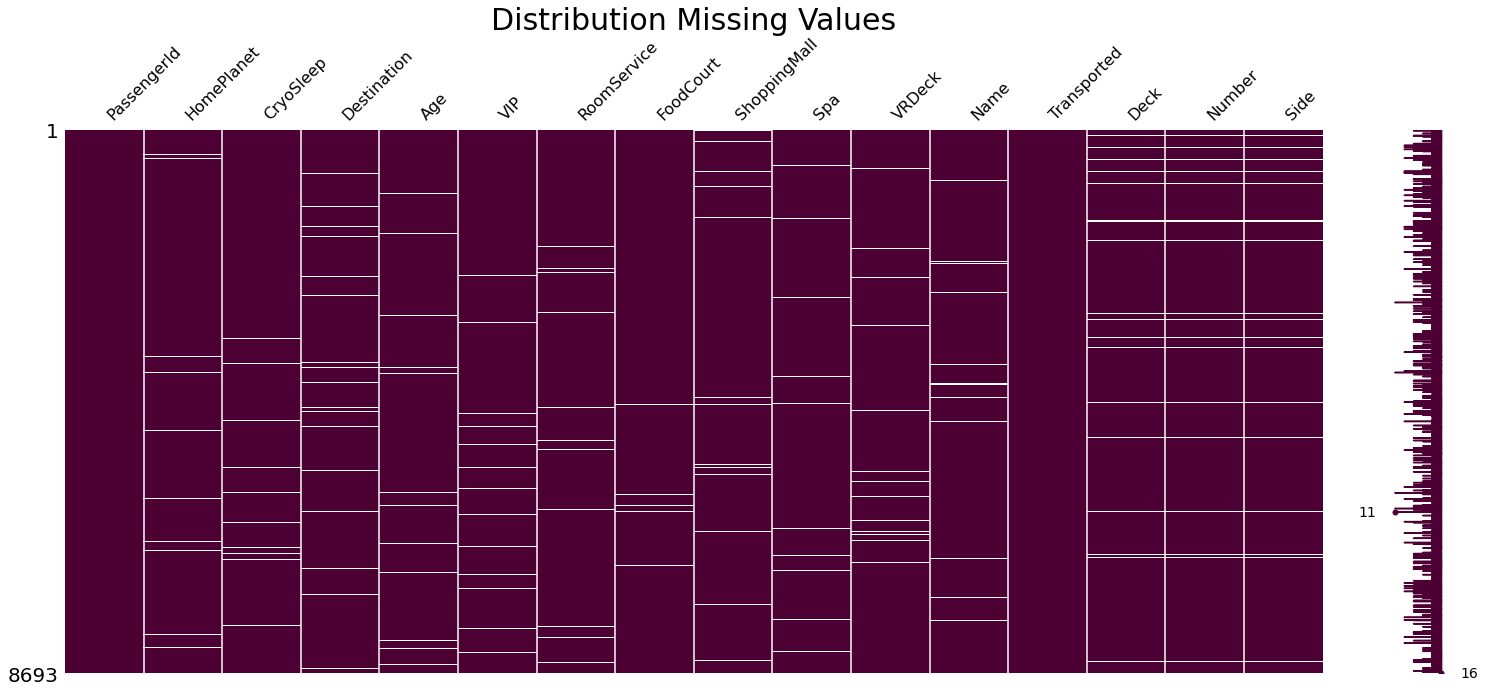

In [24]:
msno.matrix(train, color=(0.3, 0, 0.2))
plt.title('Distribution Missing Values',fontsize=30);

In [25]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Deck            199
Number          199
Side            199
dtype: int64

In [26]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
Deck               8
Number          1817
Side               2
dtype: int64

In [27]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.000,False,0.000,0.000,0.000,0.000,0.000,Maham Ofracculy,False,B,0.000,P
1,0002_01,Earth,False,TRAPPIST-1e,24.000,False,109.000,9.000,25.000,549.000,44.000,Juanna Vines,True,F,0.000,S
2,0003_01,Europa,False,TRAPPIST-1e,58.000,True,43.000,3576.000,0.000,6715.000,49.000,Altark Susent,False,A,0.000,S
3,0003_02,Europa,False,TRAPPIST-1e,33.000,False,0.000,1283.000,371.000,3329.000,193.000,Solam Susent,False,A,0.000,S
4,0004_01,Earth,False,TRAPPIST-1e,16.000,False,303.000,70.000,151.000,565.000,2.000,Willy Santantines,True,F,1.000,S


In [28]:
cat_cols = ["HomePlanet","CryoSleep","Destination","VIP","Deck","Side"] 

In [29]:
num_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

In [30]:
# We change our target variable from True/False to 1/0 so that we can use it later when examining distributions.
# 1 = True
# 0 = False
train["Transported"] = train["Transported"].apply(lambda x : 1 if x == True else 0)

In [31]:
train["Transported"]

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: Transported, Length: 8693, dtype: int64

[back to contents &#10548;](#0.)
<a class="anchor" id="4.1.1."> 
<center> <h1 style="background-color:indigo; color:white" >Analysis of Categorical Variables &#128202;</h1>
    <center>
 <a/>

        Count  Ratio  TARGET_MEAN
Earth    4602 52.939        0.424
Europa   2131 24.514        0.659
Mars     1759 20.235        0.523


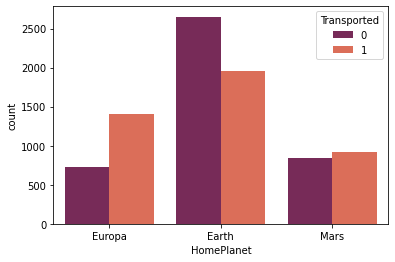

       Count  Ratio  TARGET_MEAN
False   5439 62.568        0.329
True    3037 34.936        0.818


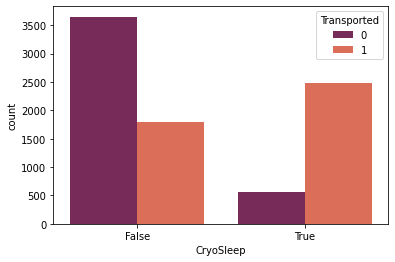

               Count  Ratio  TARGET_MEAN
55 Cancri e     1800 20.706        0.610
PSO J318.5-22    796  9.157        0.504
TRAPPIST-1e     5915 68.043        0.471


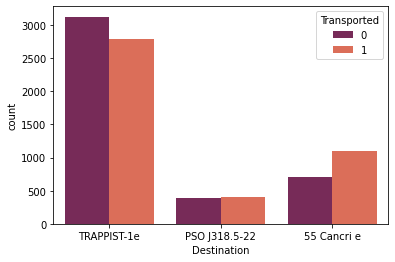

       Count  Ratio  TARGET_MEAN
False   8291 95.376        0.506
True     199  2.289        0.382


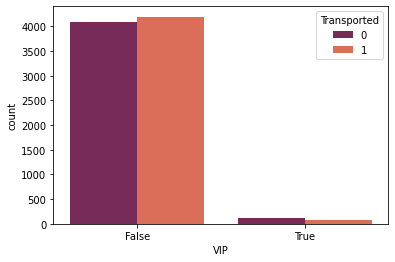

   Count  Ratio  TARGET_MEAN
A    256  2.945        0.496
B    779  8.961        0.734
C    747  8.593        0.680
D    478  5.499        0.433
E    876 10.077        0.357
F   2794 32.141        0.440
G   2559 29.437        0.516
T      5  0.058        0.200


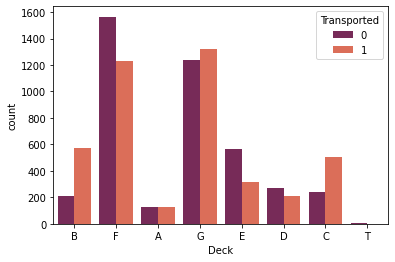

   Count  Ratio  TARGET_MEAN
P   4206 48.384        0.451
S   4288 49.327        0.555


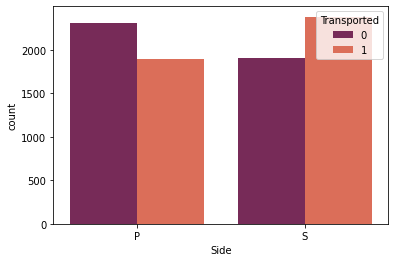

In [32]:
for col in cat_cols:
    cat_summary(train, col, 'Transported', plot=True)

[back to contents &#10548;](#0.)
<a class="anchor" id="4.1.1.1."> 
<center> <h1 style="background-color:indigo; color:white" >Handling Missing Values</h1>
    <center>
 <a/>

In [33]:
#Filling in Missing Values With the Most Repeative Data
train["HomePlanet"] = train["HomePlanet"].fillna("Earth")
train["Destination"] = train["Destination"].fillna("TRAPPIST-1e")
train["Deck"] = train["Deck"].fillna("F")
train["Side"] = train["Side"].fillna("S")

In [34]:
# Filling in Missing Values With the Mode CryoSleep
train["CryoSleep"] = train["CryoSleep"].fillna(False)

In [35]:
# Filling in Missing Values With the Mode VIP
train["VIP"] = train["VIP"].fillna(False)

[back to contents &#10548;](#0.)
<a class="anchor" id="4.1.2."> 
<center> <h1 style="background-color:indigo; color:white" >Analysis of Numerical Variables &#128202;</h1>
    <center>
 <a/>

In [36]:
#Özelliklerin kalite puanları ile ilişkisini göstermek için kullanılacak
#çizim türleri
def multi_plot(dataset, rows, cols, plot_type):
    """
    dataset: Veri seti
    rows: Satır sayısı
    cols: sütün sayısı
    plot_type: Çizdirilecek grafik türü
    """
    
    #Veri setindeki sütünların isimleri alınıyor
    column_names=dataset.columns.values
    #Kaç tane sütün olduğu bulunuyor
    number_of_column=len(column_names)
    
    #Satır*sütün boyutlarında alt grafik içeren
    #matris oluşturuluyor. Matrisin genişliği:22 yüksekliği:16
    fig, axarr=plt.subplots(rows,cols, figsize=(22,16))

    counter=0# Çizimi yapılacak özelliğin column_names listesindeki indeks değerini tutuyor
    for i in range(rows):
        for j in range(cols):
            """
            i: satır numarasını tutuyor
            j: sütün numarasını tutuyor
            axarr[i][j]: Çizilen grafigin grafik matrisindeki yerini belirliyor
            """
            if 'violin' in plot_type:
                sns.violinplot(x='transported', y=column_names[counter],data=dataset, ax=axarr[i][j],color="darkred")
            elif 'box'in plot_type :
                sns.boxplot(x='transported', y=column_names[counter],data=dataset, ax=axarr[i][j],color="darkred")
            elif 'point' in plot_type:
                sns.pointplot(x='transported',y=column_names[counter],data=dataset, ax=axarr[i][j],color="darkred")
            elif 'bar' in plot_type:
                sns.barplot(x='transported',y=column_names[counter],data=dataset, ax=axarr[i][j],color="darkred")
            elif 'line' in plot_type:
                sns.lineplot(x='transported',y=column_names[counter],data=dataset, ax=axarr[i][j],color="darkred")
                
            counter+=1
            if counter==(number_of_column-1,):
                break

In [37]:
num_cols_ = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

In [38]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.20, 0.40, 0.60, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        
        plt.figure(figsize=(12,4))  
        dataframe[numerical_col].hist(bins=30, stacked=True, histtype='barstacked',color='purple')
        plt.xlabel(numerical_col)
        plt.title("Orjinal")
        
        
        plt.figure(figsize=(12,4)) 
        dataframe[numerical_col].hist(bins=30, stacked=True, histtype='barstacked',color='orchid')
        plt.ylim([0,100])
        plt.xlabel(numerical_col)
        plt.title("Resize")
        
        plt.show()

count    8512.000
mean      224.688
std       666.718
min         0.000
5%          0.000
20%         0.000
40%         0.000
50%         0.000
60%         0.000
80%       175.600
90%       753.000
95%      1274.250
99%      3096.230
max     14327.000
Name: RoomService, dtype: float64


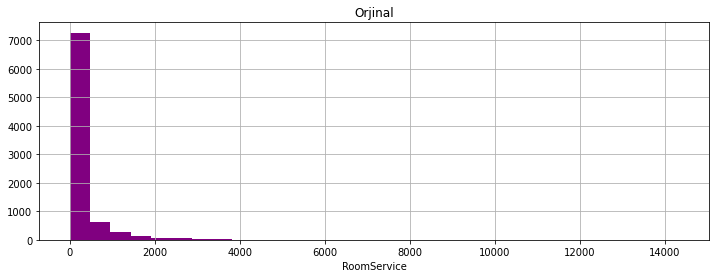

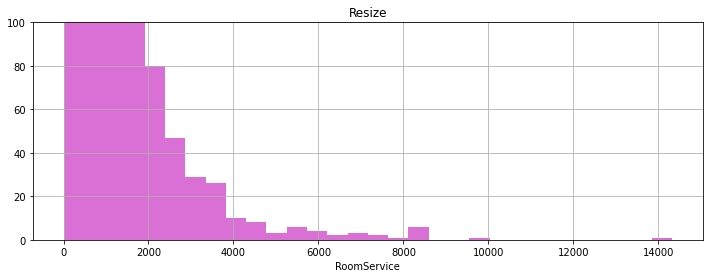

count    8510.000
mean      458.077
std      1611.489
min         0.000
5%          0.000
20%         0.000
40%         0.000
50%         0.000
60%         0.000
80%       258.000
90%      1026.000
95%      2748.500
99%      8033.310
max     29813.000
Name: FoodCourt, dtype: float64


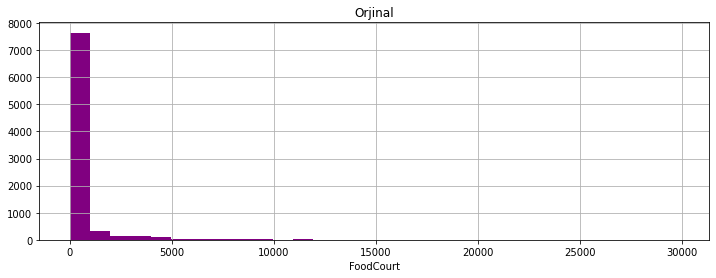

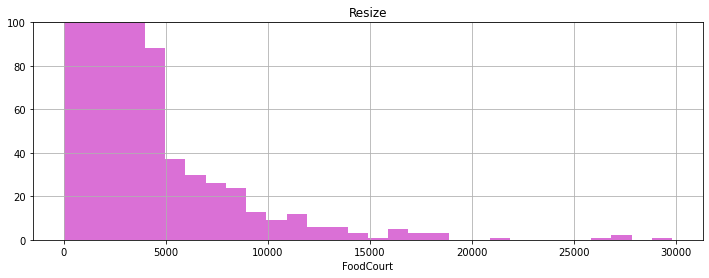

count    8485.000
mean      173.729
std       604.696
min         0.000
5%          0.000
20%         0.000
40%         0.000
50%         0.000
60%         0.000
80%        97.000
90%       619.600
95%       927.800
99%      2333.440
max     23492.000
Name: ShoppingMall, dtype: float64


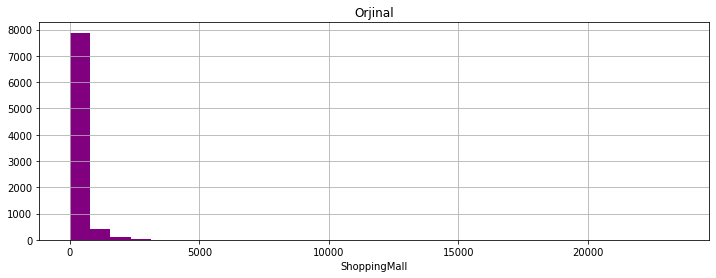

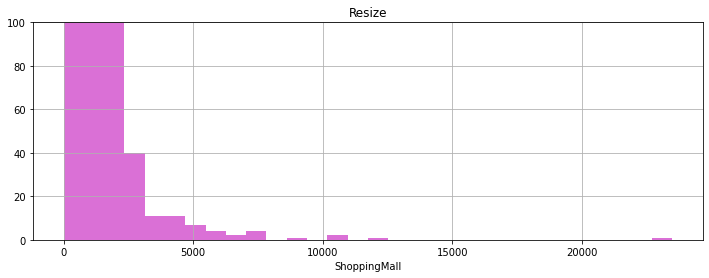

count    8510.000
mean      311.139
std      1136.706
min         0.000
5%          0.000
20%         0.000
40%         0.000
50%         0.000
60%         0.000
80%       179.200
90%       732.000
95%      1607.100
99%      5390.100
max     22408.000
Name: Spa, dtype: float64


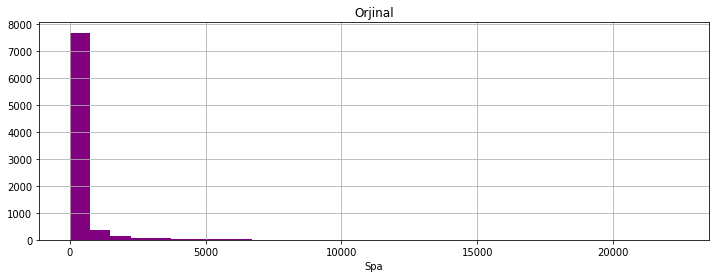

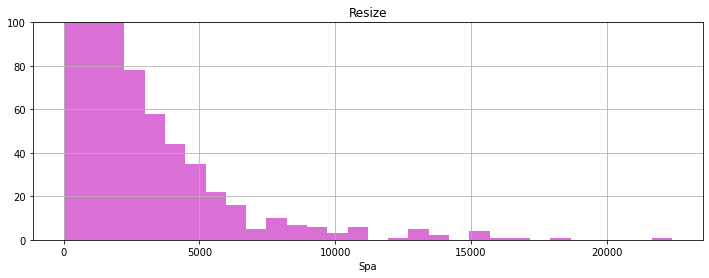

count    8505.000
mean      304.855
std      1145.717
min         0.000
5%          0.000
20%         0.000
40%         0.000
50%         0.000
60%         0.000
80%       156.200
90%       732.600
95%      1534.200
99%      5646.680
max     24133.000
Name: VRDeck, dtype: float64


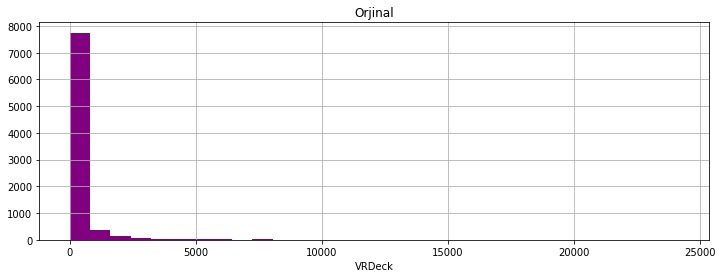

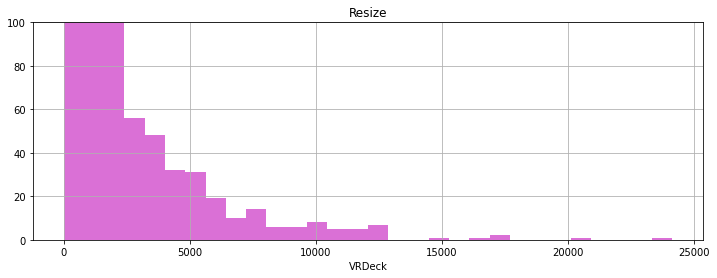

In [39]:
num_cols_ = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
for col in num_cols_:
    num_summary(train,col, plot=True)

[back to contents &#10548;](#0.)
<a class="anchor" id="4.1.2.1."> 
<center> <h1 style="background-color:indigo; color:white" >Handling Missing Values</h1>
    <center>
 <a/>

In [40]:
#Filling in Missing Values With the Most Repeative Data
train["VRDeck"] = train["VRDeck"].fillna(0)
train["Spa"] = train["Spa"].fillna(0)
train["ShoppingMall"] = train["ShoppingMall"].fillna(0)
train["FoodCourt"] = train["FoodCourt"].fillna(0)
train["RoomService"] = train["RoomService"].fillna(0)

In [41]:
train['Age'].mode()

0   24.000
dtype: float64

In [42]:
# Filling in Missing Values With the Mode Age
train["Age"] = train["Age"].fillna(24.000)

[back to contents &#10548;](#0.)
<a class="anchor" id="4.1.2.2."> 
<center> <h1 style="background-color:indigo; color:white" >Target variable analysis with numerical variables</h1>
    <center>
 <a/>

In [43]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [44]:
for col in num_cols:
    target_summary_with_num(train, "Transported", col)

               Age
Transported       
0           29.801
1           27.672


             RoomService
Transported             
0                380.425
1                 61.902


             FoodCourt
Transported           
0              375.168
1              520.646


             ShoppingMall
Transported              
0                 163.916
1                 175.147


                Spa
Transported        
0           552.349
1            60.394


             VRDeck
Transported        
0           532.291
1            67.600




[back to contents &#10548;](#0.)
<a class="anchor" id="4.1.3."> 
<center> <h1 style="background-color:indigo; color:white" >Checking for Missing Data</h1>
    <center>
 <a/>

In [45]:
train.isnull().sum().sort_values(ascending=False)

Name            200
Number          199
PassengerId       0
HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
Deck              0
Side              0
dtype: int64

In [46]:
train_df = train.copy()

[back to contents &#10548;](#0.)
<a class="anchor" id="4.1.4."> 
<center> <h1 style="background-color:indigo; color:white" >One Hot Encoding</h1>
    <center>
 <a/>

In [47]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
train_df = one_hot_encoder(train_df, cat_cols, drop_first=True)

In [48]:
train_df.head()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Number,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_True,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,0001_01,39.000,0.000,0.000,0.000,0.000,0.000,Maham Ofracculy,0,0.000,1,0,0,0,1,0,1,0,0,0,0,0,0,0
1,0002_01,24.000,109.000,9.000,25.000,549.000,44.000,Juanna Vines,1,0.000,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2,0003_01,58.000,43.000,3576.000,0.000,6715.000,49.000,Altark Susent,0,0.000,1,0,0,0,1,1,0,0,0,0,0,0,0,1
3,0003_02,33.000,0.000,1283.000,371.000,3329.000,193.000,Solam Susent,0,0.000,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0004_01,16.000,303.000,70.000,151.000,565.000,2.000,Willy Santantines,1,1.000,0,0,0,0,1,0,0,0,0,0,1,0,0,1


In [49]:
train_df["Transported"] = train_df["Transported"].apply(lambda x : True if x == 1 else False)

In [50]:
#High correlation drop
train_df = train_df.drop(["Name", "PassengerId", "Number"], axis=1)
train_df

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_True,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,39.000,0.000,0.000,0.000,0.000,0.000,False,1,0,0,0,1,0,1,0,0,0,0,0,0,0
1,24.000,109.000,9.000,25.000,549.000,44.000,True,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2,58.000,43.000,3576.000,0.000,6715.000,49.000,False,1,0,0,0,1,1,0,0,0,0,0,0,0,1
3,33.000,0.000,1283.000,371.000,3329.000,193.000,False,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4,16.000,303.000,70.000,151.000,565.000,2.000,True,0,0,0,0,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.000,0.000,6819.000,0.000,1643.000,74.000,False,1,0,0,0,0,1,0,0,0,0,0,0,0,0
8689,18.000,0.000,0.000,0.000,0.000,0.000,False,0,0,1,1,0,0,0,0,0,0,0,1,0,1
8690,26.000,0.000,0.000,1872.000,1.000,0.000,True,0,0,0,0,1,0,0,0,0,0,0,1,0,1
8691,32.000,0.000,1049.000,0.000,353.000,3235.000,False,1,0,0,0,0,0,0,0,0,1,0,0,0,1


[back to contents &#10548;](#0.)
<a class="anchor" id="4.1.5."> 
<center> <h1 style="background-color:indigo; color:white" >Editing Train Data</h1>
    <center>
 <a/>

In [51]:
X_train = train_df.drop(["Transported"], axis=1)
y_train = train_df["Transported"]

In [52]:
X_train.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_True,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,39.000,0.000,0.000,0.000,0.000,0.000,1,0,0,0,1,0,1,0,0,0,0,0,0,0
1,24.000,109.000,9.000,25.000,549.000,44.000,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2,58.000,43.000,3576.000,0.000,6715.000,49.000,1,0,0,0,1,1,0,0,0,0,0,0,0,1
3,33.000,0.000,1283.000,371.000,3329.000,193.000,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4,16.000,303.000,70.000,151.000,565.000,2.000,0,0,0,0,1,0,0,0,0,0,1,0,0,1


In [53]:
y_train.head()

0    False
1     True
2    False
3    False
4     True
Name: Transported, dtype: bool

[back to contents &#10548;](#0.)
<a class="anchor" id="4.2."> 
<center> <h1 style="background-color:indigo; color:white" >Test Values Analyze</h1>
    <center>
 <a/>

In [54]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Number,Side
0,0013_01,Earth,True,TRAPPIST-1e,27.000,False,0.000,0.000,0.000,0.000,0.000,Nelly Carsoning,G,3.000,S
1,0018_01,Earth,False,TRAPPIST-1e,19.000,False,0.000,9.000,0.000,2823.000,0.000,Lerome Peckers,F,4.000,S
2,0019_01,Europa,True,55 Cancri e,31.000,False,0.000,0.000,0.000,0.000,0.000,Sabih Unhearfus,C,0.000,S
3,0021_01,Europa,False,TRAPPIST-1e,38.000,False,0.000,6652.000,0.000,181.000,585.000,Meratz Caltilter,C,1.000,S
4,0023_01,Earth,False,TRAPPIST-1e,20.000,False,10.000,0.000,635.000,0.000,0.000,Brence Harperez,F,5.000,S


In [55]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Destination   4185 non-null   object 
 4   Age           4186 non-null   float64
 5   VIP           4184 non-null   object 
 6   RoomService   4195 non-null   float64
 7   FoodCourt     4171 non-null   float64
 8   ShoppingMall  4179 non-null   float64
 9   Spa           4176 non-null   float64
 10  VRDeck        4197 non-null   float64
 11  Name          4183 non-null   object 
 12  Deck          4177 non-null   object 
 13  Number        4177 non-null   float64
 14  Side          4177 non-null   object 
dtypes: float64(7), object(8)
memory usage: 501.3+ KB


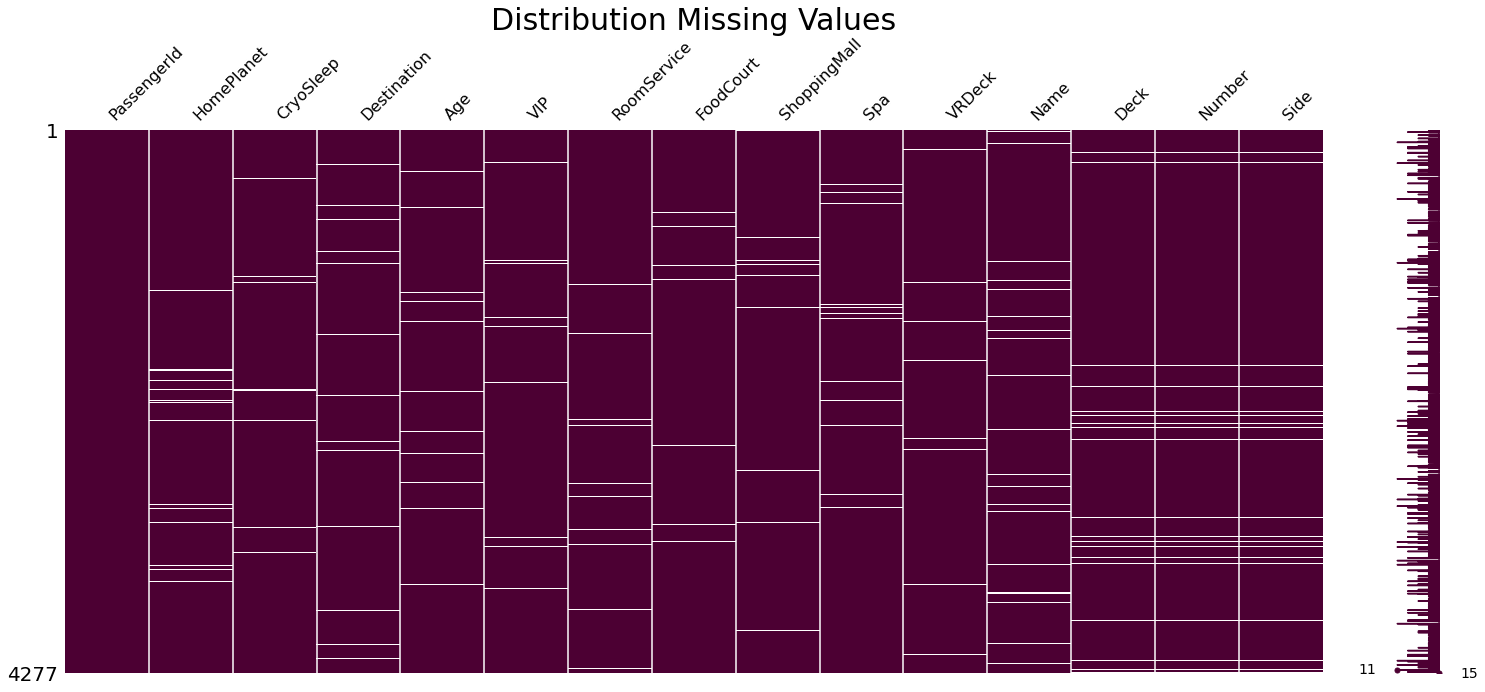

In [56]:
msno.matrix(test, color=(0.3, 0, 0.2))
plt.title('Distribution Missing Values',fontsize=30);

In [57]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Deck            100
Number          100
Side            100
dtype: int64

In [58]:
cat_cols = ["HomePlanet","CryoSleep","Destination","VIP","Deck","Side"] 

In [59]:
num_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

[back to contents &#10548;](#0.)
<a class="anchor" id="4.2.1."> 
<center> <h1 style="background-color:indigo; color:white" >Analysis of Categorical Variables (test) &#128202;</h1>
    <center>
 <a/>

        Count  Ratio
Earth    2263 52.911
Europa   1002 23.428
Mars      925 21.627


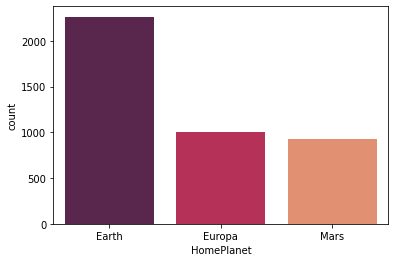

       Count  Ratio
False   2640 61.726
True    1544 36.100


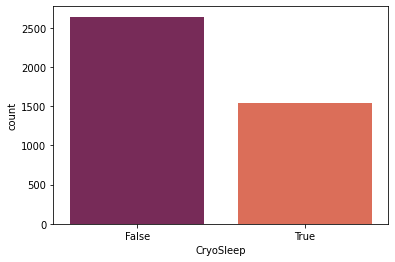

               Count  Ratio
TRAPPIST-1e     2956 69.114
55 Cancri e      841 19.663
PSO J318.5-22    388  9.072


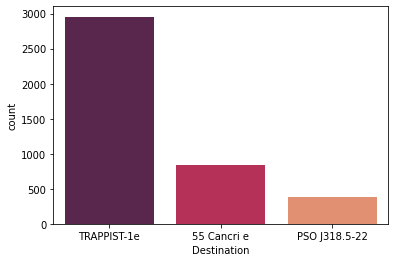

       Count  Ratio
False   4110 96.095
True      74  1.730


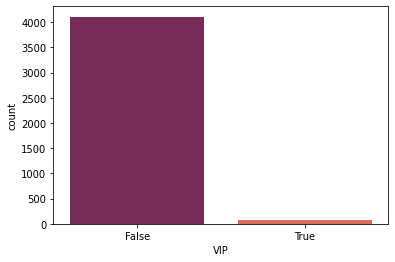

   Count  Ratio
F   1445 33.785
G   1222 28.571
E    447 10.451
B    362  8.464
C    355  8.300
D    242  5.658
A     98  2.291
T      6  0.140


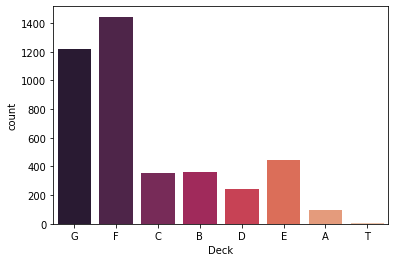

   Count  Ratio
S   2093 48.936
P   2084 48.726


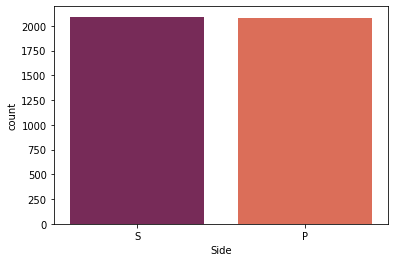

In [60]:
for col in cat_cols:
    cat_summary_test(test, col, plot=True)

[back to contents &#10548;](#0.)
<a class="anchor" id="4.2.1.1."> 
<center> <h1 style="background-color:indigo; color:white" >Handling Missing Values (test)</h1>
    <center>
 <a/>

In [61]:
#Filling in Missing Values With the Most Repeative Data
test["HomePlanet"] = test["HomePlanet"].fillna("Earth")
test["Destination"] = test["Destination"].fillna("TRAPPIST-1e")
test["Deck"] = test["Deck"].fillna("F")
test["Side"] = test["Side"].fillna("S")

In [62]:
# Filling in Missing Values With the Mode CryoSleep
test["CryoSleep"] = test["CryoSleep"].fillna(False)

In [63]:
# Filling in Missing Values With the Mode VIP
test["VIP"] = test["VIP"].fillna(False)

[back to contents &#10548;](#0.)
<a class="anchor" id="4.2.2."> 
<center> <h1 style="background-color:indigo; color:white" >Analysis of Numerical Variables (test) &#128202;</h1>
    <center>
 <a/>

count    4195.000
mean      219.266
std       607.011
min         0.000
5%          0.000
20%         0.000
40%         0.000
50%         0.000
60%         0.000
80%       182.200
90%       792.200
95%      1274.500
99%      2731.260
max     11567.000
Name: RoomService, dtype: float64


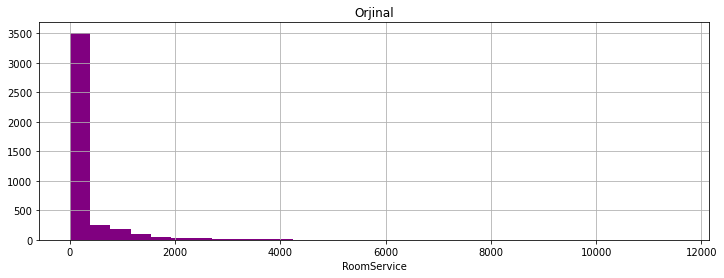

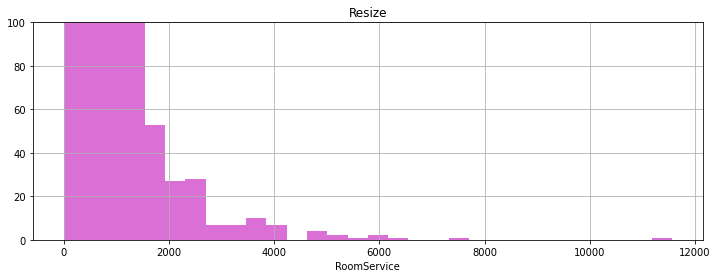

count    4171.000
mean      439.484
std      1527.663
min         0.000
5%          0.000
20%         0.000
40%         0.000
50%         0.000
60%         0.000
80%       275.000
90%       991.000
95%      2518.500
99%      7534.100
max     25273.000
Name: FoodCourt, dtype: float64


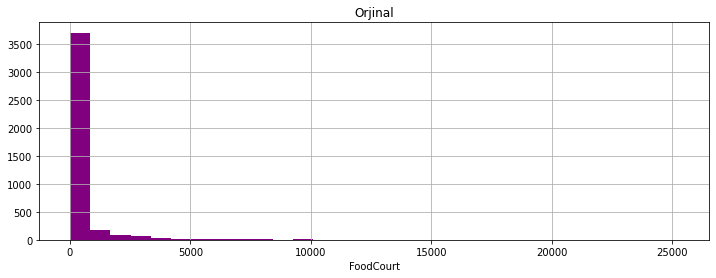

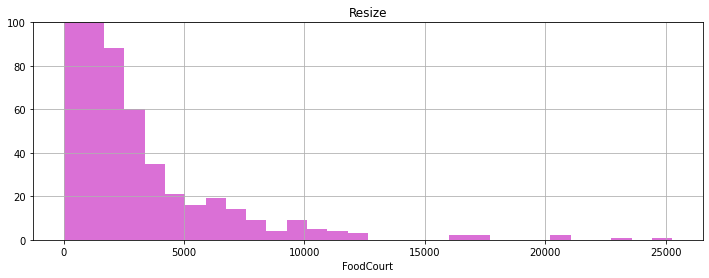

count   4179.000
mean     177.296
std      560.821
min        0.000
5%         0.000
20%        0.000
40%        0.000
50%        0.000
60%        0.000
80%      104.400
90%      631.200
95%      994.100
99%     2495.260
max     8292.000
Name: ShoppingMall, dtype: float64


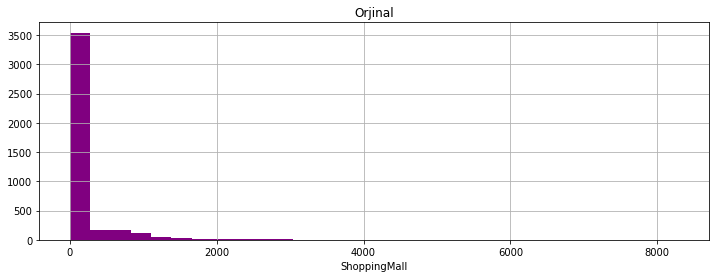

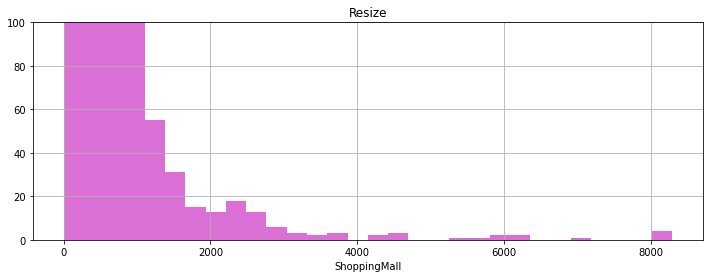

count    4176.000
mean      303.052
std      1117.186
min         0.000
5%          0.000
20%         0.000
40%         0.000
50%         0.000
60%         0.000
80%       170.000
90%       742.500
95%      1525.000
99%      5495.000
max     19844.000
Name: Spa, dtype: float64


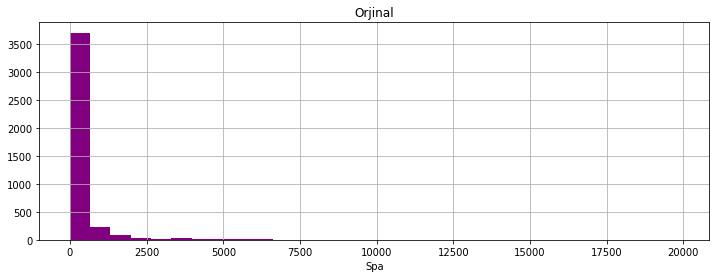

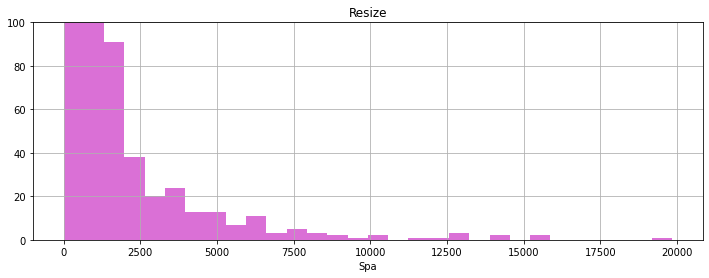

count    4197.000
mean      310.710
std      1246.995
min         0.000
5%          0.000
20%         0.000
40%         0.000
50%         0.000
60%         0.000
80%       124.000
90%       703.800
95%      1536.800
99%      5918.480
max     22272.000
Name: VRDeck, dtype: float64


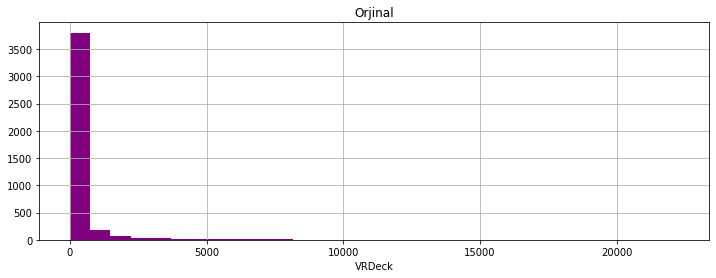

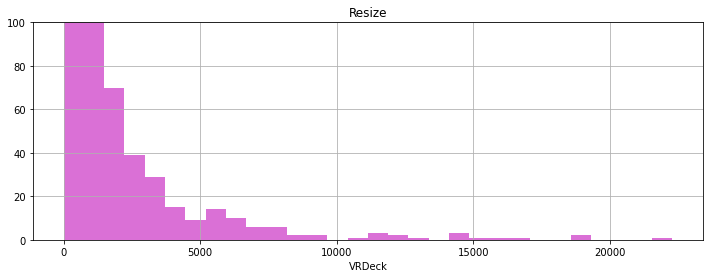

In [64]:
num_cols_ = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
for col in num_cols_:
    num_summary(test,col, plot=True)

[back to contents &#10548;](#0.)
<a class="anchor" id="4.2.2.1."> 
<center> <h1 style="background-color:indigo; color:white" >Handling Missing Values (test)</h1>
    <center>
 <a/>

In [65]:
#Filling in Missing Values With the Most Repeative Data
test["VRDeck"] = test["VRDeck"].fillna(0)
test["Spa"] = test["Spa"].fillna(0)
test["ShoppingMall"] = test["ShoppingMall"].fillna(0)
test["FoodCourt"] = test["FoodCourt"].fillna(0)
test["RoomService"] = test["RoomService"].fillna(0)

In [66]:
test["Age"].mode()

0   18.000
dtype: float64

In [67]:
# Filling in Missing Values With the Mode Age
test["Age"] = test["Age"].fillna(18.000)

[back to contents &#10548;](#0.)
<a class="anchor" id="4.2.3."> 
<center> <h1 style="background-color:indigo; color:white" >Checking for Missing Data (test)</h1>
    <center>
 <a/>

In [68]:
test.isnull().sum().sort_values(ascending=False)

Number          100
Name             94
PassengerId       0
HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Deck              0
Side              0
dtype: int64

In [69]:
test_df= test.copy()

[back to contents &#10548;](#0.)
<a class="anchor" id="4.2.4."> 
<center> <h1 style="background-color:indigo; color:white" >One Hot Encoding (test)</h1>
    <center>
 <a/>


In [70]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
test_df = one_hot_encoder(test_df, cat_cols, drop_first=True)

In [71]:
test_df.head()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Number,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_True,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,0013_01,27.000,0.000,0.000,0.000,0.000,0.000,Nelly Carsoning,3.000,0,0,1,0,1,0,0,0,0,0,0,1,0,1
1,0018_01,19.000,0.000,9.000,0.000,2823.000,0.000,Lerome Peckers,4.000,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2,0019_01,31.000,0.000,0.000,0.000,0.000,0.000,Sabih Unhearfus,0.000,1,0,1,0,0,0,0,1,0,0,0,0,0,1
3,0021_01,38.000,0.000,6652.000,0.000,181.000,585.000,Meratz Caltilter,1.000,1,0,0,0,1,0,0,1,0,0,0,0,0,1
4,0023_01,20.000,10.000,0.000,635.000,0.000,0.000,Brence Harperez,5.000,0,0,0,0,1,0,0,0,0,0,1,0,0,1


[back to contents &#10548;](#0.)
<a class="anchor" id="4.2.5."> 
<center> <h1 style="background-color:indigo; color:white" >Editing Test Data</h1>
    <center>
 <a/>

In [72]:
X_test = test_df.drop(["Name", "Number","PassengerId"],axis=1)

In [73]:
X_test.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_True,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,27.000,0.000,0.000,0.000,0.000,0.000,0,0,1,0,1,0,0,0,0,0,0,1,0,1
1,19.000,0.000,9.000,0.000,2823.000,0.000,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2,31.000,0.000,0.000,0.000,0.000,0.000,1,0,1,0,0,0,0,1,0,0,0,0,0,1
3,38.000,0.000,6652.000,0.000,181.000,585.000,1,0,0,0,1,0,0,1,0,0,0,0,0,1
4,20.000,10.000,0.000,635.000,0.000,0.000,0,0,0,0,1,0,0,0,0,0,1,0,0,1


[back to contents &#10548;](#0.)
<a class="anchor" id="5."> 
<center> <h1 style="background-color:indigo; color:white" >Random Forest &#127795;</h1>
    <center>
 <a/>

In [74]:
rf_model = RandomForestClassifier(random_state=17)

In [75]:
# Default Parameters
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [76]:
# Parameters Defined for the Test
rf_params = {"max_depth": [7, 8, 9, 10],
             "max_features": [4, 5, 6, 7],
             "min_samples_split": [5, 6, 7, 8 ,9],
             "n_estimators": [100, 200, 300]}

In [77]:
#Finding the Best Parameters
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=10, n_jobs=-1, verbose=True).fit(X_train, y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


In [78]:
rf_best_grid.best_params_

{'max_depth': 9,
 'max_features': 5,
 'min_samples_split': 5,
 'n_estimators': 200}

In [79]:
#Training the Model
rf_final = rf_model.set_params(**rf_best_grid.best_params_).fit(X_train, y_train)

In [80]:
# Model Prepared with the Best Parameters
y_pred_rf = rf_final.predict(X_test)

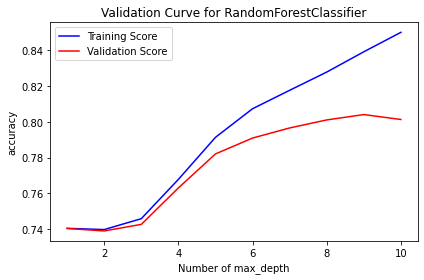

In [81]:
# Accuracy and Maximum Depth Curve
val_curve_params(rf_final, X_train, y_train, "max_depth", range(1, 11), scoring="accuracy")  

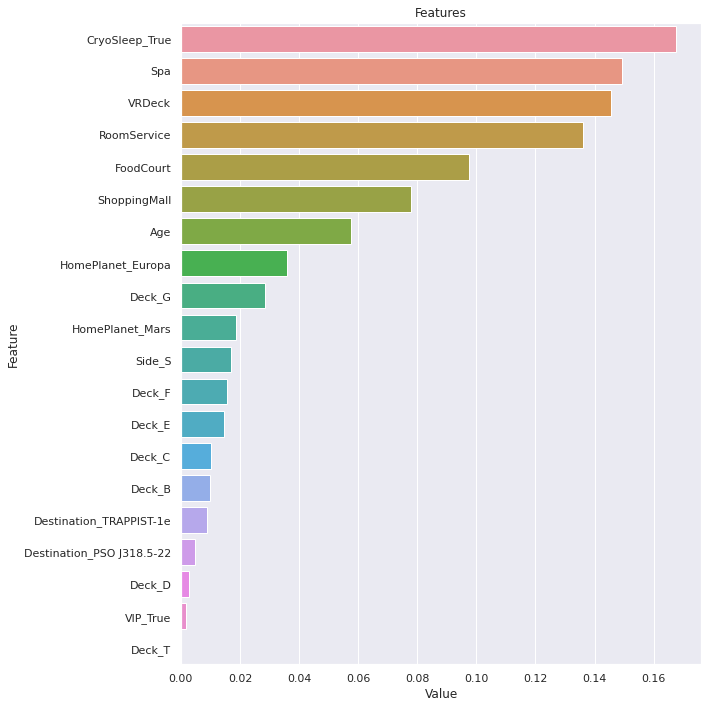

In [82]:
def plot_importance(model, features, num=len(X_train), save=True):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
# Importance Graphics
plot_importance(rf_final, X_train) 

[back to contents &#10548;](#0.)
<a class="anchor" id="6."> 
<center> <h1 style="background-color:indigo; color:white" >Gradient Boosting Machine &#128297;</h1>
    <center>
 <a/>

In [83]:
gbm_model = GradientBoostingClassifier(random_state=17)

In [84]:
# Default Parameters
gbm_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 17,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [85]:
# Parameters Defined for the Test
gbm_params = {"learning_rate": [0.01, 0.02, 0.1],
              "max_depth": [6, 7, 8, 9],
              "n_estimators": [100, 200, 400, 600],
              "subsample": [0.3, 0.4, 0.6, 0.8]}

In [86]:
#Finding the Best Parameters
gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=10, n_jobs=-1, verbose=True).fit(X_train, y_train)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


In [87]:
gbm_best_grid.best_params_

{'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 400, 'subsample': 0.4}

In [88]:
#Training the Model
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X_train, y_train)

In [89]:
# Model Prepared with the Best Parameters
y_pred_gbm = gbm_final.predict(X_test)

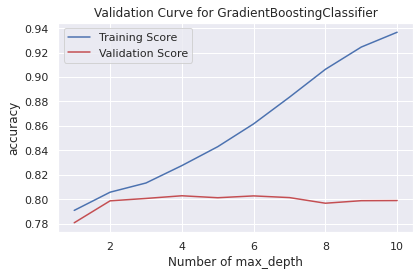

In [90]:
# Accuracy and Maximum Depth Curve
val_curve_params(gbm_final, X_train, y_train, "max_depth", range(1, 11), scoring="accuracy") 

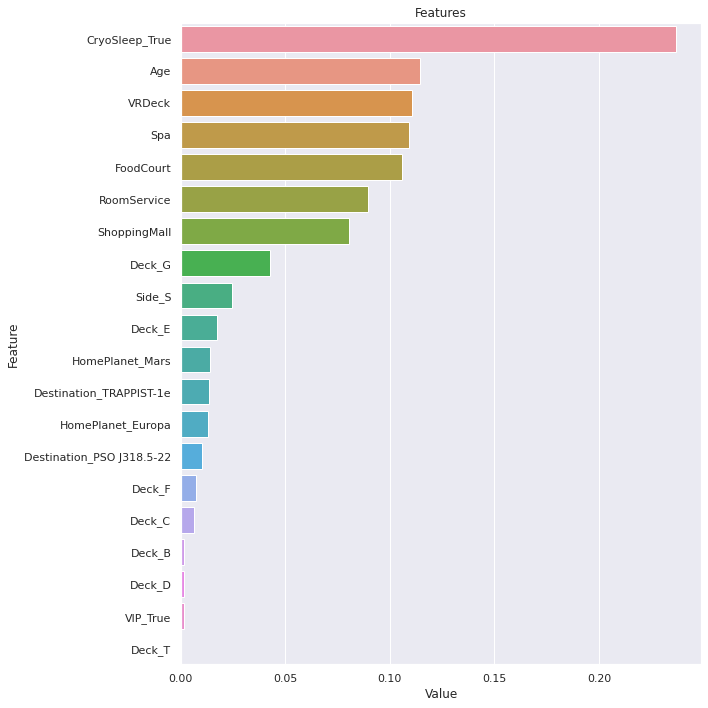

In [91]:
def plot_importance(model, features, num=len(X_train), save=True):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
# Importance Graphics
plot_importance(gbm_final, X_train)

[back to contents &#10548;](#0.)
<a class="anchor" id="7."> 
<center> <h1 style="background-color:indigo; color:white" >eXtreme Gradient Boosting &#128295;</h1>
    <center>
 <a/>

In [92]:
# Default Model
xgboost_model = XGBClassifier(random_state=17, use_label_encoder=False)

In [93]:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 6, 7],
                  "n_estimators": [600, 700, 800],
                  "colsample_bytree": [0.5, 0.7, 1]}

In [94]:
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=10, n_jobs=-1, verbose=True).fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [95]:
xgboost_best_grid.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 700}

In [96]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X_train, y_train)

In [97]:
# Model Prepared with the Best Parameters
y_pred_xgb = xgboost_final.predict(X_test)

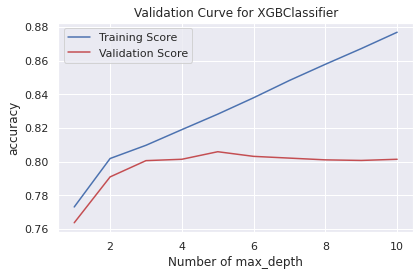

In [98]:
# Accuracy and Maximum Depth Curve
val_curve_params(xgboost_final, X_train, y_train, "max_depth", range(1, 11), scoring="accuracy") 

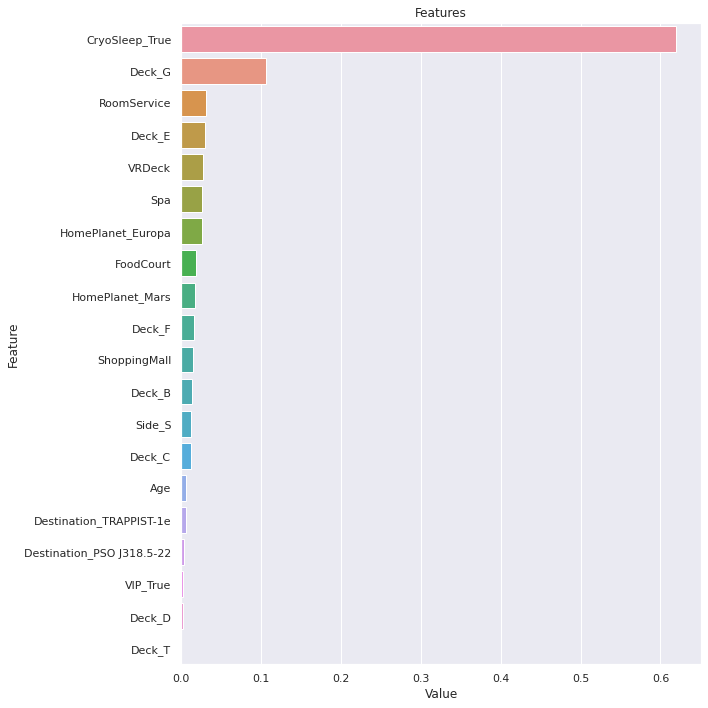

In [99]:
def plot_importance(model, features, num=len(X_train), save=True):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
# Importance Graphics
plot_importance(xgboost_final, X_train)

[back to contents &#10548;](#0.)
<a class="anchor" id="8."> 
<center> <h1 style="background-color:indigo; color:white" >Light Gradient Boosting Machine &#128294;</h1>
    <center>
 <a/>

In [100]:
# Default Model
lgbm_model = LGBMClassifier(random_state=17)

In [101]:
lgbm_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 6, 7],
                  "n_estimators": [600, 700, 800],
                  "subsample": [0.3, 0.4, 0.6]}

In [102]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=10, n_jobs=-1, verbose=True).fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [103]:
lgbm_best_grid.best_params_

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 600, 'subsample': 0.3}

In [104]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X_train, y_train)

In [105]:
# Model Prepared with the Best Parameters
y_pred_lgbm = lgbm_final.predict(X_test)

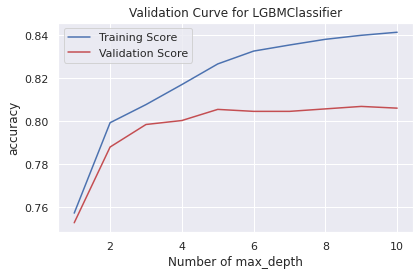

In [106]:
# Accuracy and Maximum Depth Curve
val_curve_params(lgbm_final, X_train, y_train, "max_depth", range(1, 11), scoring="accuracy") 

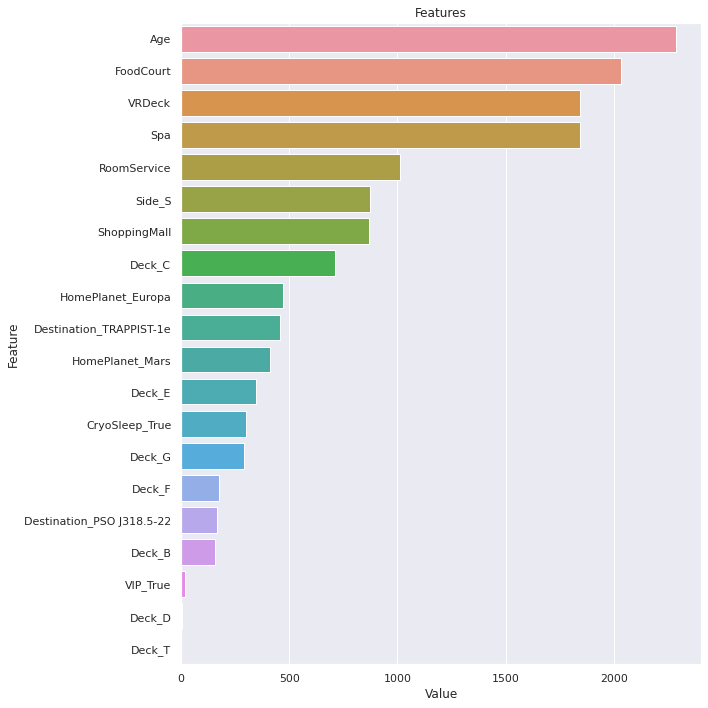

In [107]:
def plot_importance(model, features, num=len(X_train), save=True):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
# Importance Graphics
plot_importance(lgbm_final, X_train)

[back to contents &#10548;](#0.)
<a class="anchor" id="9."> 
<center> <h1 style="background-color:indigo; color:white" >Accuracy table of models &#128187;</h1>
    <center>
 <a/>

In [108]:
models = ["Random Forest",
          "Gradient Boosting Machine",
          "XGBoost",
          "LightGBM",
          ]

train_acc = [
    accuracy_score(y_train, rf_final.predict(X_train)),
    accuracy_score(y_train, gbm_final.predict(X_train)),
    accuracy_score(y_train, xgboost_final.predict(X_train)),
    accuracy_score(y_train, lgbm_final.predict(X_train)),
]
pd.DataFrame({
    
    "Model":models,
    "Train Accuracy": train_acc   
})

,Model,Train Accuracy
0,Random Forest,0.837
1,Gradient Boosting Machine,0.856
2,XGBoost,0.827
3,LightGBM,0.825


In [109]:
rf = rf_final
model = rf.fit(X_train, train.Transported)
y_predprob = model.predict_proba(X_test)[:,1]
ypred = [True if i > 0.4 else False for i in y_predprob]

test["Transported"] = ypred
submission = test[["PassengerId", "Transported"]]
submission.to_csv("submission_rf.csv", columns = ["PassengerId", "Transported"], index = None)

In [110]:
gbm = gbm_final
model = gbm.fit(X_train, train.Transported)
y_predprob = model.predict_proba(X_test)[:,1]
ypred = [True if i > 0.5 else False for i in y_predprob]

test["Transported"] = ypred
submission = test[["PassengerId", "Transported"]]
submission.to_csv("submission_gbm.csv", columns = ["PassengerId", "Transported"], index = None)

In [111]:
xgb = xgboost_final
model = xgb.fit(X_train, train.Transported)
y_predprob = model.predict_proba(X_test)[:,1]
ypred = [True if i > 0.5 else False for i in y_predprob]

test["Transported"] = ypred
submission = test[["PassengerId", "Transported"]]
submission.to_csv("submission_xgb.csv", columns = ["PassengerId", "Transported"], index = None)

In [112]:
lgbm = lgbm_final
model = lgbm.fit(X_train, train.Transported)
y_predprob = model.predict_proba(X_test)[:,1]
ypred = [True if i > 0.5 else False for i in y_predprob]

test["Transported"] = ypred
submission = test[["PassengerId", "Transported"]]
submission.to_csv("submission.csv", columns = ["PassengerId", "Transported"], index = None)

[back to contents &#10548;](#0.)
<a class="anchor" id="10."> 
<center> <h1 style="background-color:indigo; color:white" >THANK YOU &#127881;</h1>
    <center>
 <a/>